## EEG Stress Detection

In [50]:
import sagemaker
sagemaker_session = sagemaker.Session()

prefix = 'sagemaker/eeg-stress'
role = sagemaker.get_execution_role()

In [2]:
# import modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

Matplotlib is building the font cache; this may take a moment.


In [1]:
def get_default_device():
    '''Pick gpu if available else pick cpu'''
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    '''Move tensors to choosen device'''
    if isinstance(data, (list, tuple)):
        return [to_device(d, device) for d in data]
    return data.to(device, non_blocking=True)

In [3]:
device = get_default_device()

In [4]:
eeg_data = pd.read_csv("emotions.csv")
eeg_data.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


In [5]:
labels = eeg_data['label'].value_counts()
labels

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64

In [6]:
eeg_data['label'] = eeg_data['label'].replace(['NEUTRAL', 'NEGATIVE', 'POSITIVE'],['CALM', 'STRESSED', 'GOOD-MOOD'])

In [7]:
labels = eeg_data['label'].value_counts()
labels

CALM         716
STRESSED     708
GOOD-MOOD    708
Name: label, dtype: int64

### Data Preprocessing

In [8]:
# do not change original dataset
eeg_data_copy = eeg_data.copy()

In [9]:
# label encoding
eeg_data['label'] = eeg_data['label'].astype('category').cat.codes

In [10]:
# split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(eeg_data.drop('label', axis=1), eeg_data['label'], random_state=42, test_size=0.2, stratify=eeg_data['label'])

In [11]:
y_train.value_counts()

0    573
2    566
1    566
Name: label, dtype: int64

In [12]:
y_test.value_counts()

0    143
2    142
1    142
Name: label, dtype: int64

In [13]:
# convert test to numpy
y_test = y_test.to_numpy()
# convert to numpy arrays
inputs_array = X_train.to_numpy()
targets_array = y_train.to_numpy()

In [14]:
# convert to tensors
inputs = to_device(torch.FloatTensor(inputs_array),device)
targets = to_device(torch.FloatTensor(targets_array), device)

In [15]:
# define batch size
batch_size = 128

In [16]:
# build a GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(GRUModel, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.gru = nn.GRU(input_size, hidden_dim, n_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_size).float()
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out, h = self.gru(x)
        out = self.fc(self.relu(out))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        return hidden

In [18]:
input_size = len(X_train.columns)
output_size = len(y_train.unique())
hidden_dim = 128
n_layers = 2
# init hyperparameters
n_epochs = 500
# init model
GRUmodel = GRUModel(input_size, output_size, hidden_dim, n_layers)

In [19]:
to_device(GRUmodel, device)

GRUModel(
  (gru): GRU(2548, 128, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=128, out_features=3, bias=True)
  (relu): ReLU()
)

In [20]:
#Training the GRU Model
#define loss and optimizer
losses = []
l_rates = [1e-1, 1e-2, 1e-3, 1e-4]
l_r_i = 2
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(GRUmodel.parameters(), l_rates[l_r_i])
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.01)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() 
    output, hidden = GRUmodel(inputs.unsqueeze(0))
    loss = criterion(output.squeeze(0).float(), targets.long())
    loss_detached = loss.detach().cpu().clone().numpy()
    losses.append(loss_detached)

    loss.backward() 
    optimizer.step()

    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/500............. Loss: 0.8903
Epoch: 20/500............. Loss: 0.7263
Epoch: 30/500............. Loss: 0.6505
Epoch: 40/500............. Loss: 0.6266
Epoch: 50/500............. Loss: 0.6042
Epoch: 60/500............. Loss: 0.5884
Epoch: 70/500............. Loss: 0.5670
Epoch: 80/500............. Loss: 0.5533
Epoch: 90/500............. Loss: 0.5363
Epoch: 100/500............. Loss: 0.5187
Epoch: 110/500............. Loss: 0.5014
Epoch: 120/500............. Loss: 0.4750
Epoch: 130/500............. Loss: 0.4562
Epoch: 140/500............. Loss: 0.4229
Epoch: 150/500............. Loss: 0.4037
Epoch: 160/500............. Loss: 0.3797
Epoch: 170/500............. Loss: 0.3575
Epoch: 180/500............. Loss: 0.3315
Epoch: 190/500............. Loss: 0.3065
Epoch: 200/500............. Loss: 0.2827
Epoch: 210/500............. Loss: 0.2458
Epoch: 220/500............. Loss: 0.2238
Epoch: 230/500............. Loss: 0.1953
Epoch: 240/500............. Loss: 0.1822
Epoch: 250/500...........

### Prediction and Testing

In [21]:
test_data = to_device(torch.FloatTensor(X_test.to_numpy()).unsqueeze(0), device)
output = GRUmodel(test_data)[0]
output = output.squeeze(0)
output_ = output.detach().cpu().clone()
predictions = np.array(torch.argmax(output_, 1, keepdim=True))

<AxesSubplot:>

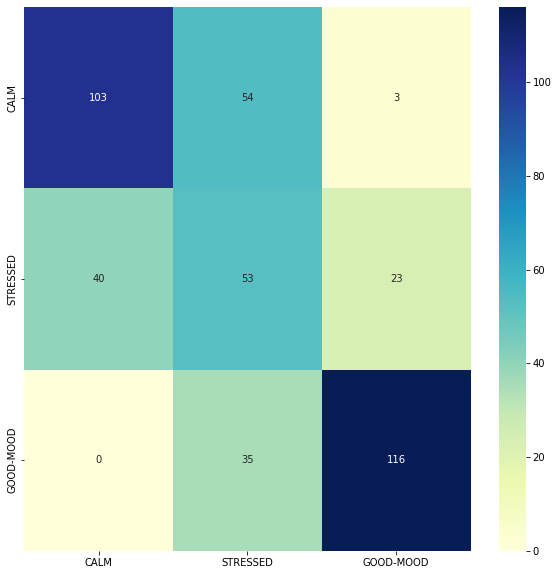

In [22]:
c_m = confusion_matrix(predictions, y_test)

plt.figure(figsize=(10, 10))
sbn.heatmap(c_m, annot=True, cmap='YlGnBu', fmt='g', yticklabels=list(labels.index), xticklabels=list(labels.index))

In [23]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.64      0.72      0.68       143
           1       0.46      0.37      0.41       142
           2       0.77      0.82      0.79       142

    accuracy                           0.64       427
   macro avg       0.62      0.64      0.63       427
weighted avg       0.62      0.64      0.63       427



### Performing inference on a sample model

In [46]:
#Test model on an random incoming snippet
test_array = np.ones((1, 1, 2548))
test_point = to_device(torch.FloatTensor(test_array),device)
output = GRUmodel(test_point)[0]
print(output)
output_ = output.detach().cpu().clone()
prediction = torch.argmax(output_)

label_dict= {0:'STRESSED', 1:'CALM', 2:'GOOD-MOOD'}
prediction = label_dict[int(prediction)]

tensor([[[ 0.1198, -0.0644,  0.1606]]], grad_fn=<AddBackward0>)


In [47]:
prediction

'GOOD-MOOD'

### Saving Model for Inference